**Tarners Method With Application of ML**

---


Problem - A Volumetric-oil reservoir has a bubble-point pressure of 2100 psi at
175°F. The initial reservoir pressure is 2925 psi. Using given fluid and rock properties and PVT data predict Np, Gp at 4 different avg res pressures.


**Required Packages**

In [1]:
# Importing Modules
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import xgboost as xgb

**Function definitions**

In [2]:
# Functions For Undersaturated
def undersaturated(Sw, Cw, Cf, P1, P2, Bo, Boi):
    Efw = Boi*( (Cw*Sw + Cf)/(1-Sw) )*(P1-P2)
    print(Efw)
    Eo = Bo - Boi
    print(Eo)
    Np = N*pow(10,6)*(Eo+Efw)/Bo
    return Np

# Functions For Saturated
def GOR(Rel_perm, Visc_ratio, Rs, Bo, Bg):
    gor = Rs + Rel_perm*Visc_ratio*(Bo/Bg)
    return gor
    
def OilSat(Sw, Np, N, Bo, Boi):
    So = (1-Sw)*(1-(Np/N))*(Bo/Boi)
    return So
    
def Mbe(Np2, N, Rsi, Rs, Bo, Bg, Boi):
    Gp_mbe = N*( (Rsi-Rs) - ((Boi-Bo)/Bg) ) - (Np2*(Bo/Bg - Rs))
    return Gp_mbe

**Importing Data**

In [11]:
# Meant For Volumetric Reservoir 

# Importing PVT data
data = pd.read_excel('TA.xlsx')
Rel_perm_data = pd.read_excel('TA2.xlsx')

# Reservoir Data To be given By the User
N= 10 #in MMSTB
Sw = 0.15
por = 0.12
Cw = 3.6 * pow(10,-6)#in psi−1
Cf = 4.9 * pow(10,-6) #in psi−1

# Showing PVT data
data

,SNO,P(psi),B0(bbl/stb),Bt(bbl/scf),Rs(SCF/STB),Bg(bbl/stb),uo/ug
0,1,2925,1.429,1.429,1340,NaN,NaN
1,2,2100,1.480,1.480,1340,0.001283,34.1
2,3,1800,1.468,1.559,1280,0.001518,38.3
3,4,1500,1.440,1.792,1150,0.001853,42.4


**Fitting XGB to get correlation b/w Relative Permeability and OIl sat**

[16:27:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


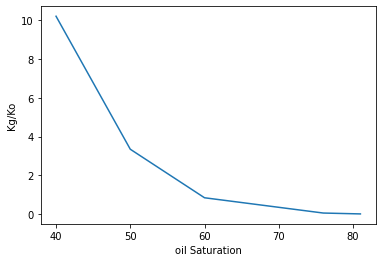

In [5]:
# Obtaining Curve For Relative Permeability as a function of Oil Saturation

x = Rel_perm_data.iloc[:,0].values
x = x.reshape(x.shape[0], 1)
y = Rel_perm_data.iloc[:,1].values

xgbr = xgb.XGBRegressor() 
reg = xgbr.fit(x, y)

# Plotting Rel Perm vs oil Saturation curve
plt.plot(x,y)
plt.xlabel('oil Saturation')
plt.ylabel('Kg/Ko')
plt.show()

**Tarners Iterative Approach**

In [ ]:
# Container For storing pressure and cummulative Production Data
column_names = ['Average Res Pressure', 'Cumm. Oil Production', 'Cumm. Gas Prod']
prod_pred = pd.DataFrame(columns = column_names)

i = 0
Bo = 1.480
Boi= data.iloc[0,2]
P1 = data.iloc[i,1]
P2 = data.iloc[i+1,1]
Rsi = 1340

Oil_Prod_undersat = undersaturated(Sw, Cw, Cf, P1, P2, Bo, Boi)
Gas_prod_undersat = Rsi*Oil_Prod_undersat
prod_pred = prod_pred.append({'Average Res Pressure':P1, 'Cumm. Oil Production':0, 
                      'Cumm. Gas Prod': 0}, ignore_index = True)
prod_pred = prod_pred.append({'Average Res Pressure':P2, 'Cumm. Oil Production':Oil_Prod_undersat, 
                      'Cumm. Gas Prod': Gas_prod_undersat}, ignore_index = True)

###################################

# P = 1800 Psi
i = 1
N = N*pow(10,6)-Oil_Prod_undersat
Rsi = data.iloc[i,4]
Boi = data.iloc[i,2]
Bgi = data.iloc[i,5]
comm_prod = []

for i in range(1,data.shape[0]-1):
    Np1 =0 
    Np2 = 100
    P1 = data.iloc[i,1]
    P2 = data.iloc[i+1,1]
    
    Rs =  data.iloc[i+1,4]
    Bo =  data.iloc[i+1,2]
    Bg =  data.iloc[i+1,5]
    Visc_ratio = data.iloc[i+1, 6]
    Gp1 = 0
    gor1 = Rsi
    
    
    Np2 = Np2 + 10
    
    rate = 10
    while(Np2 < N):
        Np2 = Np2 + rate
        print(Np2)
        Gp1 = Gp1
        Gp2 = Mbe(Np2, N, Rsi, Rs, Bo, Bg, Boi)
        print(Gp2/N)
        So = OilSat(Sw, Np2, N, Bo, Boi)
        #print(So)
        k_ = np.array([So*100])
        k_ = k_.reshape(k_.shape[0], 1)
        
        Rel_perm = reg.predict(k_)
        
        gor1 = gor1
        gor2 = GOR(Rel_perm, Visc_ratio, Rs, Bo, Bg)
        
        gor_avg = (gor1+gor2)/2*(Np2-Np1) 
        Gp2_gor = Gp1 + gor_avg
        print(Gp2_gor/N)
        print('\n')
        error = abs((Gp2_gor - Gp2)/N)
        print(error)
        if error < 2:
            prod_pred = prod_pred.append({'Average Res Pressure':P2, 'Cumm. Oil Production':Np2+Oil_Prod_undersat, 
                      'Cumm. Gas Prod': Gp2}, ignore_index = True)
            comm_prod.append(Np2)
            Gp1 = Gp2
            Np1 = Np2
            gor1 = gor2
            break

**Performance Prediction Curve PLot**

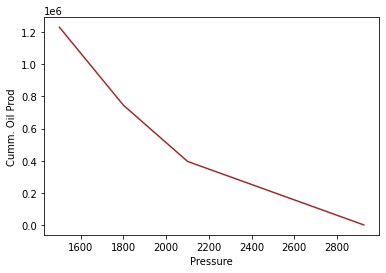

In [7]:
# Cumm OIl production           
plt.plot(prod_pred['Average Res Pressure'], prod_pred['Cumm. Oil Production'], color='brown')
plt.xlabel('Pressure')
plt.ylabel('Cumm. Oil Prod')
plt.show()

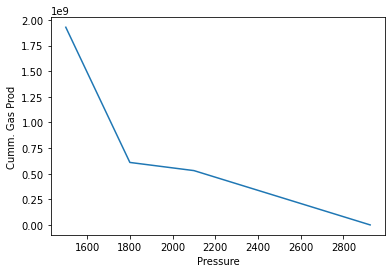

In [8]:
# Cumm Gas Production
plt.plot(prod_pred['Average Res Pressure'], prod_pred['Cumm. Gas Prod'])
plt.xlabel('Pressure')
plt.ylabel('Cumm. Gas Prod')
plt.show()